In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import reshape_as_image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from sklearn.model_selection import train_test_split
import glob,os,sys,cv2
from datetime import datetime
import visualkeras
from PIL import ImageFont

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [59]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(256,256,12))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # model = keras.Sequential()
    # bn = tf.keras.Model(inputs,bottleneck)
    
    flat = layers.Flatten()(bottleneck)
    reg_layer = layers.Dense(64, activation='relu')(flat) # Add another dense layer
    reg_layer = Dropout(0.5)(reg_layer)
    reg_layer = layers.Dense(32, activation='relu')(reg_layer)
    reg_layer = layers.Dense(16, activation='relu')(reg_layer)
    reg_layer = layers.Dense(8, activation='relu')(reg_layer)
    reg_layer = layers.Dense(4, activation='relu')(reg_layer)
    reg_layer = layers.Dense(1,activation='linear')(reg_layer)
    

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    # outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs=inputs, outputs=[outputs,reg_layer], name="U-Net Multi Head")

    return unet_model


unet_model = build_unet_model()

In [60]:
unet_model.summary()

Model: "U-Net Multi Head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_383 (Conv2D)            (None, 256, 256, 64  6976        ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_384 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_383[0][0]']             
                                )                                                  

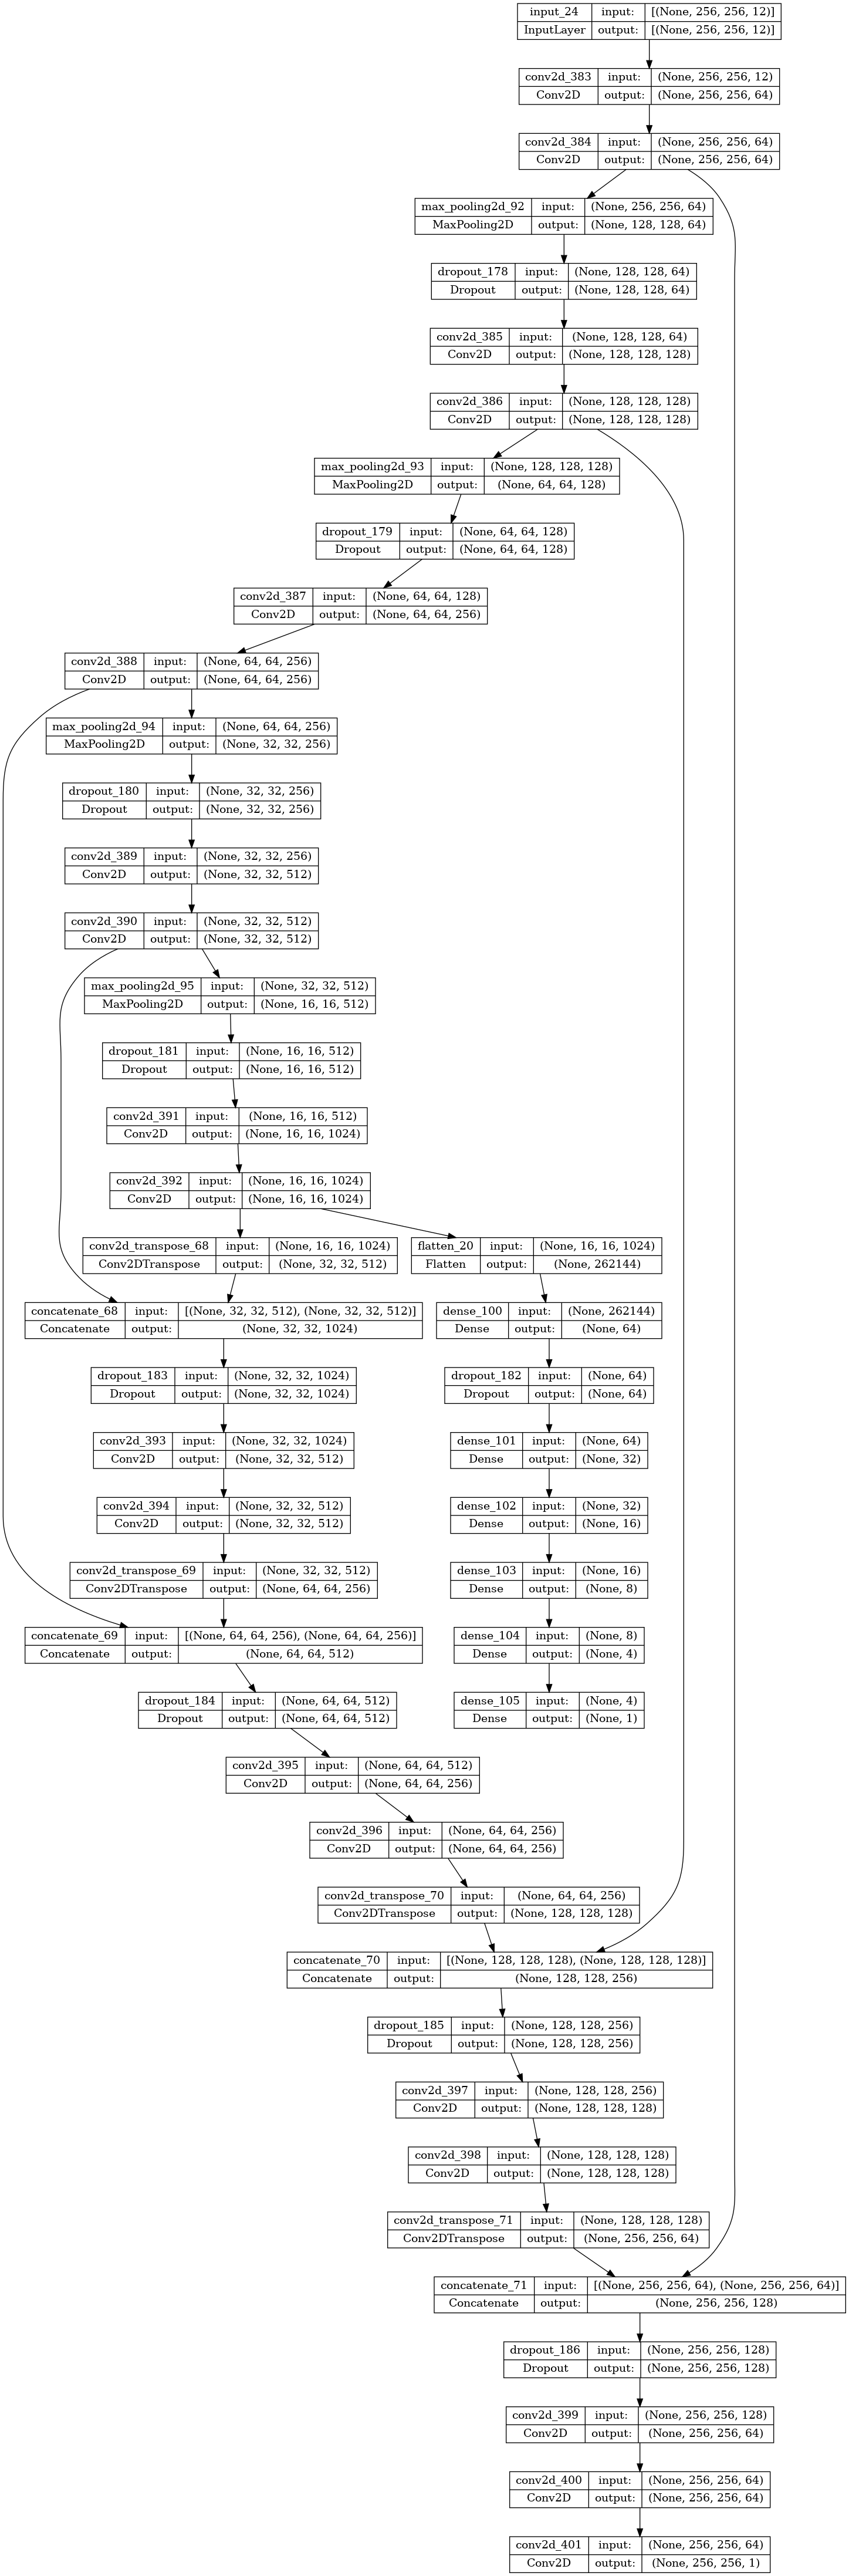

In [61]:
from keras.utils.vis_utils import plot_model
plot_model(unet_model, to_file='Unet__model_2.png', show_shapes=True, show_layer_names=True)
